In [8]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

NUM_WORKERS = 0
BATCH_TRAIN = 64
BATCH_EVAL  = 256
EPOCHS = 25
LR = 1e-3

CANVAS = 128
PASTE  = 28

N_VIS = 8
CAM_THR = 0.4

OUT_DIR = "./out"
os.makedirs(OUT_DIR, exist_ok=True)

Using device: cpu


In [9]:
class CanvasFashionMNIST(Dataset):
   
    def __init__(self, base_ds, canvas_size=128, paste_size=28, normalize=True):
        self.base = base_ds
        self.C = canvas_size
        self.P = paste_size
        self.normalize = normalize

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        img, y = self.base[idx]  
        canvas = torch.zeros((1, self.C, self.C), dtype=img.dtype)

        max_xy = self.C - self.P
        x0 = random.randint(0, max_xy)
        y0 = random.randint(0, max_xy)

        canvas[:, y0:y0+self.P, x0:x0+self.P] = img

        if self.normalize:
            canvas = (canvas - 0.5) / 0.5

        bbox = torch.tensor([x0, y0, x0+self.P-1, y0+self.P-1], dtype=torch.long)
        return canvas, y, bbox

In [10]:
base_tf = transforms.ToTensor()
train_base = datasets.FashionMNIST(root="./data", train=True, download=True, transform=base_tf)
test_base  = datasets.FashionMNIST(root="./data", train=False, download=True, transform=base_tf)

full_train = CanvasFashionMNIST(train_base, canvas_size=CANVAS, paste_size=PASTE, normalize=True)
full_test  = CanvasFashionMNIST(test_base,  canvas_size=CANVAS, paste_size=PASTE, normalize=True)

val_ratio = 0.1
n_val = int(len(full_train) * val_ratio)
n_train = len(full_train) - n_val
train_ds, val_ds = random_split(full_train, [n_train, n_val])

train_loader = DataLoader(train_ds, batch_size=BATCH_TRAIN, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_EVAL,  shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(full_test,batch_size=BATCH_EVAL,  shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

x, y, bbox = next(iter(train_loader))
print(x.shape, y.shape, bbox.shape)  

torch.Size([64, 1, 128, 128]) torch.Size([64]) torch.Size([64, 4])


In [11]:
class CNN_CAM(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),             

            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),              

            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),              

            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU()
        )
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(64, num_classes)

    def forward(self, x):
        fmap = self.features(x)          
        v = self.gap(fmap).flatten(1)    
        logits = self.classifier(v)     
        return logits, fmap

model = CNN_CAM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

print(model)

CNN_CAM(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
  )
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
  (classifier): Linear(in_features=64, out_features=10, bias=True)
)


In [12]:
def run_epoch(loader, train=True):
    model.train(train)
    total_loss, correct, total = 0.0, 0, 0

    for x, y, _bbox in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        if train:
            optimizer.zero_grad(set_to_none=True)

        logits, _ = model(x)
        loss = criterion(logits, y)

        if train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    return total_loss / total, correct / total

history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

for ep in range(1, EPOCHS + 1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc = run_epoch(val_loader, train=False)

    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["train_acc"].append(tr_acc)
    history["val_acc"].append(va_acc)

    print(f"Epoch {ep:02d} | Train loss {tr_loss:.4f} acc {tr_acc:.4f} | Val loss {va_loss:.4f} acc {va_acc:.4f}")

Epoch 01 | Train loss 1.2123 acc 0.5529 | Val loss 0.7853 acc 0.7100
Epoch 02 | Train loss 0.7280 acc 0.7258 | Val loss 0.6967 acc 0.7370
Epoch 03 | Train loss 0.6822 acc 0.7421 | Val loss 0.6404 acc 0.7512
Epoch 04 | Train loss 0.6214 acc 0.7623 | Val loss 0.6393 acc 0.7505
Epoch 05 | Train loss 0.5889 acc 0.7757 | Val loss 0.5946 acc 0.7680
Epoch 06 | Train loss 0.5607 acc 0.7868 | Val loss 0.5651 acc 0.7900
Epoch 07 | Train loss 0.5263 acc 0.8026 | Val loss 0.5196 acc 0.8067
Epoch 08 | Train loss 0.5060 acc 0.8126 | Val loss 0.4949 acc 0.8212
Epoch 09 | Train loss 0.4720 acc 0.8268 | Val loss 0.4706 acc 0.8258
Epoch 10 | Train loss 0.4514 acc 0.8357 | Val loss 0.4484 acc 0.8398
Epoch 11 | Train loss 0.4339 acc 0.8422 | Val loss 0.4401 acc 0.8465
Epoch 12 | Train loss 0.4214 acc 0.8465 | Val loss 0.4226 acc 0.8448
Epoch 13 | Train loss 0.4055 acc 0.8511 | Val loss 0.4111 acc 0.8500
Epoch 14 | Train loss 0.3893 acc 0.8574 | Val loss 0.4120 acc 0.8473
Epoch 15 | Train loss 0.3821 acc 0

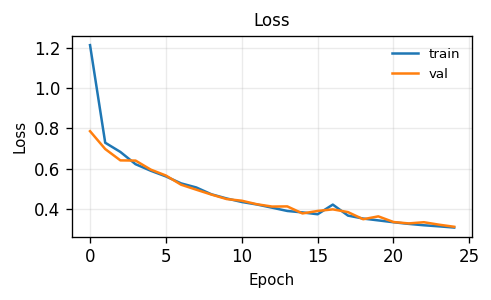

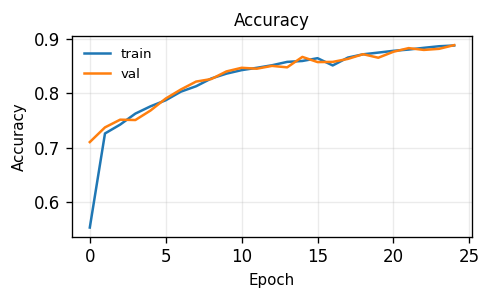

Saved: ./out/loss_curve.png, ./out/acc_curve.png


In [ ]:
fig, ax = plt.subplots(figsize=(4.2, 2.6), dpi=120)
ax.plot(history["train_loss"], label="train")
ax.plot(history["val_loss"], label="val")
ax.set_title("Loss", fontsize=10)
ax.set_xlabel("Epoch", fontsize=9)
ax.set_ylabel("Loss", fontsize=9)
ax.grid(True, alpha=0.25)
ax.legend(fontsize=8, frameon=False)
fig.tight_layout()
fig.savefig(os.path.join(OUT_DIR, "loss_curve.png"), dpi=150, bbox_inches="tight")
plt.show()
plt.close(fig)

fig, ax = plt.subplots(figsize=(4.2, 2.6), dpi=120)
ax.plot(history["train_acc"], label="train")
ax.plot(history["val_acc"], label="val")
ax.set_title("Accuracy", fontsize=10)
ax.set_xlabel("Epoch", fontsize=9)
ax.set_ylabel("Accuracy", fontsize=9)
ax.grid(True, alpha=0.25)
ax.legend(fontsize=8, frameon=False)
fig.tight_layout()
fig.savefig(os.path.join(OUT_DIR, "acc_curve.png"), dpi=150, bbox_inches="tight")
plt.show()
plt.close(fig)

print(f"Saved: {OUT_DIR}/loss_curve.png, {OUT_DIR}/acc_curve.png")

Test ROC-AUC (OvR): 0.9904437944444444


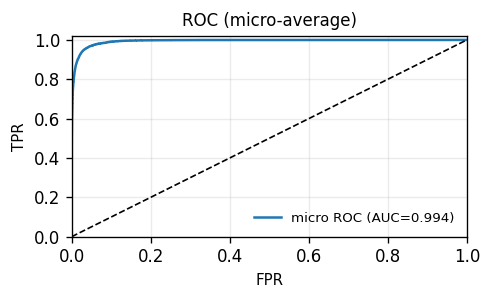

Saved: ./out/roc_micro.png


In [14]:
model.eval()
all_probs, all_labels = [], []

with torch.no_grad():
    for x, y, _bbox in test_loader:
        x = x.to(device, non_blocking=True)
        logits, _ = model(x)
        probs = F.softmax(logits, dim=1).cpu().numpy()
        all_probs.append(probs)
        all_labels.append(y.numpy())

y_true = np.concatenate(all_labels)
y_prob = np.concatenate(all_probs)

y_onehot = np.eye(10)[y_true]
roc_auc_ovr = roc_auc_score(y_onehot, y_prob, multi_class="ovr")
print("Test ROC-AUC (OvR):", roc_auc_ovr)

y_test_bin = label_binarize(y_true, classes=np.arange(10))
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
auc_micro = auc(fpr_micro, tpr_micro)

fig, ax = plt.subplots(figsize=(4.2, 2.6), dpi=120)
ax.plot(fpr_micro, tpr_micro, label=f"micro ROC (AUC={auc_micro:.3f})")
ax.plot([0, 1], [0, 1], "k--", linewidth=1)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1.02)
ax.set_xlabel("FPR", fontsize=9)
ax.set_ylabel("TPR", fontsize=9)
ax.set_title("ROC (micro-average)", fontsize=10)
ax.grid(True, alpha=0.25)
ax.legend(fontsize=8, frameon=False)
fig.tight_layout()

fig.savefig(os.path.join(OUT_DIR, "roc_micro.png"), dpi=150, bbox_inches="tight")
plt.show()
plt.close(fig)

print(f"Saved: {OUT_DIR}/roc_micro.png")

In [15]:
classes = (
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
)

c:\Users\Rayan Service\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Saved CAM overlays: ./out/cam_overlay_*.png
IoU per sample: [0.732, 0.211, 0.551, 0.49, 0.623, 0.509, 0.437, 0.517]
Mean IoU: 0.5088645447460828


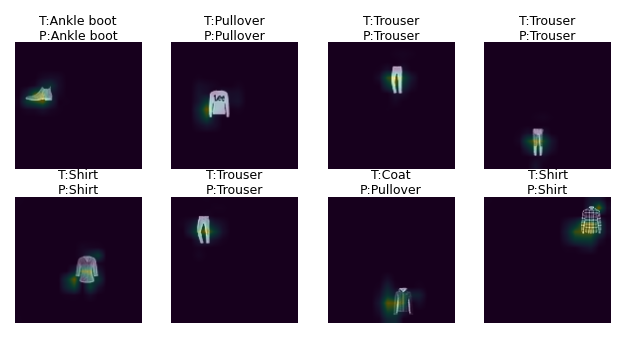

In [16]:
def cam_from_head(features_1, classifier_weight_for_class):
    cam = torch.einsum("c,chw->hw", classifier_weight_for_class, features_1)
    cam = F.relu(cam)
    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-6)
    return cam

def cam_to_bbox(cam_2d, thr=0.4):
    m = cam_2d >= thr
    if not m.any():
        return None
    ys, xs = np.where(m)
    return int(xs.min()), int(ys.min()), int(xs.max()), int(ys.max())

def iou(boxA, boxB):
    if boxA is None or boxB is None:
        return 0.0
    ax1, ay1, ax2, ay2 = boxA
    bx1, by1, bx2, by2 = boxB

    inter_x1 = max(ax1, bx1)
    inter_y1 = max(ay1, by1)
    inter_x2 = min(ax2, bx2)
    inter_y2 = min(ay2, by2)

    inter_w = max(0, inter_x2 - inter_x1 + 1)
    inter_h = max(0, inter_y2 - inter_y1 + 1)
    inter_area = inter_w * inter_h

    areaA = (ax2 - ax1 + 1) * (ay2 - ay1 + 1)
    areaB = (bx2 - bx1 + 1) * (by2 - by1 + 1)
    union = areaA + areaB - inter_area
    return inter_area / union if union > 0 else 0.0



model.eval()
x_batch, y_batch, bbox_true = next(iter(test_loader))
n = min(N_VIS, x_batch.size(0))
x_vis = x_batch[:n].to(device, non_blocking=True)

with torch.no_grad():
    logits, fmap = model(x_vis)
    preds = logits.argmax(1)

ious = []


for i in range(n):
    features_i = fmap[i]
    pred_cls = int(preds[i].item())
    w_cls = model.classifier.weight[pred_cls]
    cam_hw = cam_from_head(features_i, w_cls)

    cam_128 = F.interpolate(cam_hw[None, None, ...], size=(CANVAS, CANVAS),
                            mode="bilinear", align_corners=False)[0, 0]
    cam_128_np = cam_128.detach().cpu().numpy()

    pred_bbox = cam_to_bbox(cam_128_np, thr=CAM_THR)
    true_bbox = tuple(bbox_true[i].tolist())
    ious.append(iou(pred_bbox, true_bbox))

    img_np = x_vis[i][0].detach().cpu().numpy()
    img_np = np.clip((img_np * 0.5) + 0.5, 0, 1)

    true_name = classes[int(y_batch[i])]
    pred_name = classes[pred_cls]

    fig, ax = plt.subplots(figsize=(3.0, 3.0), dpi=120)
    ax.imshow(img_np, cmap="gray")
    ax.imshow(cam_128_np, alpha=0.35)
    ax.set_title(f"T:{true_name}\nP:{pred_name} | IoU={ious[-1]:.2f}", fontsize=8)
    ax.axis("off")
    fig.tight_layout()

    fig.savefig(os.path.join(OUT_DIR, f"cam_overlay_{i}.png"), dpi=150, bbox_inches="tight")
    plt.close(fig)

print(f"Saved CAM overlays: {OUT_DIR}/cam_overlay_*.png")
print("IoU per sample:", [round(v, 3) for v in ious])
print("Mean IoU:", float(np.mean(ious)))

show_k = min(24, n)   
ncols = 4            
nrows = int(np.ceil(show_k / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(1.05*ncols, 1.05*nrows), dpi=150)
axes = np.array(axes).reshape(-1)

for ax in axes:
    ax.axis("off")

for j in range(show_k):
    img_np = x_vis[j][0].detach().cpu().numpy()
    img_np = np.clip((img_np * 0.5) + 0.5, 0, 1)

    features_j = fmap[j]
    pred_cls_j = int(preds[j].item())
    w_cls_j = model.classifier.weight[pred_cls_j]
    cam_hw_j = cam_from_head(features_j, w_cls_j)
    cam_128_j = F.interpolate(cam_hw_j[None, None, ...], size=(CANVAS, CANVAS),
                              mode="bilinear", align_corners=False)[0, 0].detach().cpu().numpy()

    true_name = classes[int(y_batch[j])]
    pred_name = classes[pred_cls_j]

    axes[j].imshow(img_np, cmap="gray")
    axes[j].imshow(cam_128_j, alpha=0.35)
    axes[j].set_title(f"T:{true_name}\nP:{pred_name}", fontsize=6, pad=1)
    axes[j].axis("off")

fig.tight_layout(pad=0.2)
plt.show()
plt.close(fig)

Saved Grad-CAM overlays: ./out/gradcam_overlay_*.png


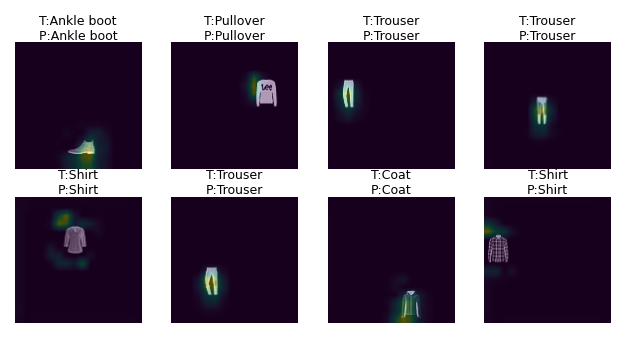

In [17]:
class GradCAM:
    def __init__(self, model):
        self.model = model
        self.fmap = None
        self.grad = None

        target_layer = None
        for layer in reversed(list(model.features)):
            if isinstance(layer, nn.Conv2d):
                target_layer = layer
                break
        if target_layer is None:
            raise RuntimeError("No Conv2d layer found for Grad-CAM.")

        target_layer.register_forward_hook(self._save_fmap)
        target_layer.register_full_backward_hook(self._save_grad)

    def _save_fmap(self, module, inp, out):
        self.fmap = out

    def _save_grad(self, module, grad_in, grad_out):
        self.grad = grad_out[0]

    def __call__(self, x):
        self.model.zero_grad(set_to_none=True)
        logits, _ = self.model(x)
        cls = logits.argmax(1)

        idx = torch.arange(x.size(0), device=x.device)
        score = logits[idx, cls].sum()
        score.backward()

        w = self.grad.mean(dim=(2, 3), keepdim=True)
        cam = (w * self.fmap).sum(dim=1, keepdim=True)
        cam = F.relu(cam)

        cam = cam - cam.amin(dim=(2, 3), keepdim=True)
        cam = cam / (cam.amax(dim=(2, 3), keepdim=True) + 1e-6)
        cam = F.interpolate(cam, size=(CANVAS, CANVAS), mode="bilinear", align_corners=False)
        return cam.detach(), cls.detach()

gradcam = GradCAM(model)

model.eval()
torch.set_grad_enabled(True)

x_batch, y_batch, bbox_true = next(iter(test_loader))
n = min(N_VIS, x_batch.size(0))
x_g = x_batch[:n].to(device, non_blocking=True)

cam_g, cls_g = gradcam(x_g)
cam_g_np = cam_g[:, 0].detach().cpu().numpy()
cls_g_np = cls_g.detach().cpu().numpy()

for i in range(n):
    img_np = x_g[i][0].detach().cpu().numpy()
    img_np = np.clip((img_np * 0.5) + 0.5, 0, 1)

    true_name = classes[int(y_batch[i])]
    pred_name = classes[int(cls_g_np[i])]

    fig, ax = plt.subplots(figsize=(3.0, 3.0), dpi=120)
    ax.imshow(img_np, cmap="gray")
    ax.imshow(cam_g_np[i], alpha=0.35)
    ax.set_title(f"T:{true_name}\nP:{pred_name}", fontsize=8)
    ax.axis("off")
    fig.tight_layout()

    fig.savefig(os.path.join(OUT_DIR, f"gradcam_overlay_{i}.png"), dpi=150, bbox_inches="tight")
    plt.close(fig)

print(f"Saved Grad-CAM overlays: {OUT_DIR}/gradcam_overlay_*.png")

show_k = min(24, n)
ncols = 4
nrows = int(np.ceil(show_k / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(1.05*ncols, 1.05*nrows), dpi=150)
axes = np.array(axes).reshape(-1)

for ax in axes:
    ax.axis("off")

for j in range(show_k):
    img_np = x_g[j][0].detach().cpu().numpy()
    img_np = np.clip((img_np * 0.5) + 0.5, 0, 1)

    true_name = classes[int(y_batch[j])]
    pred_name = classes[int(cls_g_np[j])]

    axes[j].imshow(img_np, cmap="gray")
    axes[j].imshow(cam_g_np[j], alpha=0.35)
    axes[j].set_title(f"T:{true_name}\nP:{pred_name}", fontsize=6, pad=1)
    axes[j].axis("off")

fig.tight_layout(pad=0.2)
plt.show()
plt.close(fig)

In [18]:
summary_path = os.path.join(OUT_DIR, "metrics_summary.txt")

device_name = str(device)
if device_name.startswith("cuda"):
    try:
        device_name = f"cuda ({torch.cuda.get_device_name(0)})"
    except Exception:
        device_name = "cuda"

mean_iou = float(np.mean(ious)) if len(ious) > 0 else float("nan")

lines = [
    f"Device: {device_name}",
    f"Epochs: {EPOCHS}",
    f"Final Train Acc: {history['train_acc'][-1]:.4f}",
    f"Final Val Acc: {history['val_acc'][-1]:.4f}",
    f"Test ROC-AUC (OvR): {roc_auc_ovr:.6f}",
    f"CAM threshold: {CAM_THR}",
    f"Mean IoU (first {n} samples): {mean_iou:.6f}",
]

with open(summary_path, "w", encoding="utf-8") as f:
    f.write("\n".join(lines) + "\n")

outputs = [
    "loss_curve.png",
    "acc_curve.png",
    "roc_micro.png",
    "cam_overlay_*.png",
    "gradcam_overlay_*.png (optional)",
    "metrics_summary.txt",
]

print(f"Saved summary to: {summary_path}")
print("Outputs saved to ./out/:")
for item in outputs:
    print("-", item)

display(Markdown("### Metrics Summary"))
display(Markdown("```\n" + "\n".join(lines) + "\n```"))

Saved summary to: ./out\metrics_summary.txt
Outputs saved to ./out/:
- loss_curve.png
- acc_curve.png
- roc_micro.png
- cam_overlay_*.png
- gradcam_overlay_*.png (optional)
- metrics_summary.txt


### Metrics Summary

```
Device: cpu
Epochs: 25
Final Train Acc: 0.8875
Final Val Acc: 0.8882
Test ROC-AUC (OvR): 0.990444
CAM threshold: 0.4
Mean IoU (first 8 samples): 0.508865
```